In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score

%matplotlib inline

# a function to draw a plot of an SVM
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    x_min, x_max = X[:, 0].min()-pad, X[:, 0].max()+pad
    y_min, y_max = X[:, 1].min()-pad, X[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X[:,0], X[:,1], s=70, c=y, cmap=mpl.cm.Paired)
    sv = svc.support_vectors_
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

In [111]:
landmarks = pd.read_csv('./data/tidyLandmarks_AT.csv')
landmarks['landmark_index'] = pd.to_numeric(landmarks.landmark_index, errors='coerce').values
landmarks['r'] = pd.to_numeric(landmarks.r, errors='coerce').values
landmarks['pts'] = pd.to_numeric(landmarks.pts, errors='coerce').values
landmarks.head()

,landmark_index,sample_index,min_alpha,max_alpha,min_theta,max_theta,num,pts,r,stype
0,1,1,-14.29,-4.76,-0.79,0.00,50,19,12.885591,mt-zrf
1,2,1,-14.29,-4.76,-1.57,-0.79,50,0,NaN,mt-zrf
2,3,1,-14.29,-4.76,-2.36,-1.57,50,0,NaN,mt-zrf
3,4,1,-14.29,-4.76,-3.14,-2.36,50,0,NaN,mt-zrf
4,5,1,-14.29,-4.76,0.00,0.79,50,1,2.318041,mt-zrf


## missing values

In [106]:
r_means = []
#land = pd.to_numeric(landmarks.landmark_index, errors='coerce').values
for i in range(1, int(max(landmarks['landmark_index']))+1):
    chosenLandmark = landmarks[landmarks.landmark_index==i]
    chosenLandmark = chosenLandmark[chosenLandmark.num != 0]
    r_means.append(np.mean(chosenLandmark.r))

In [108]:
for i in range(0, len(landmarks)):
    if (landmarks.iloc[i]['pts']==0):
        landmarks.loc[i,'r'] = r_means[landmarks.iloc[i]['landmark_index'] - 1]

In [110]:
landmarks.to_csv("tidyLandmarks_AT_no_na.csv", sep=',')

## SVM Method 

In [15]:
def svm_classification(landmarks, index):
    # filter out the landmarks needed
    chosenLandmark = landmarks[landmarks.landmark_index==index]
    
    # create training and testing data
    X = chosenLandmark[['pts', 'r']]
    y = chosenLandmark['stype']
    y = y.replace(['mt-zrf'], 1)
    y = y.replace(['wt-zrf'], 0)
    
    
    # present the data
    plt.figure(figsize=(8, 5))
    plt.scatter(X.values[:,0], X.values[:,1], s=30, c=y, cmap=mpl.cm.Paired, alpha=0.8)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    
    # find the best C value by cross-validation
    tuned_parameters = [{'C': [0.1, 1, 10]}]

    clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy')
    clf.fit(X.values, y.values)
    best_c = clf.best_params_['C']
    
    svc = SVC(C=1, kernel='linear')
    svc.fit(X, y)
    
    plot_svc(svc, X.values, y)
    
    prediction = svc.predict(X)
    # print confusion matrix
    print("confusion matrix: ")
    cm = confusion_matrix(y, prediction)
    cm_df = pd.DataFrame(cm.T, index=svc.classes_, columns=svc.classes_)
    print(cm_df)
    print('Classification Report: ')
    print(classification_report(y, 
                            prediction,
                            digits = 3))
    # print results
    print('Classification Accuracy Results: ')
    ww =0
    wm = 0
    mm = 0
    mw = 0
    
    for i in range (len(y)):
        _y = y.values[i]
        _p = prediction[i]

        if _y==1 and _p==1:
            mm = mm + 1
        elif _y==1 and _p==0:
            mw = mw + 1
        elif _y==0 and _p==0:
            ww = ww + 1
        elif _y==0 and _p==1:
            wm = wm + 1

    
    return svc, ww, wm, mm, mw

## Testing SVM Method 

index: 1


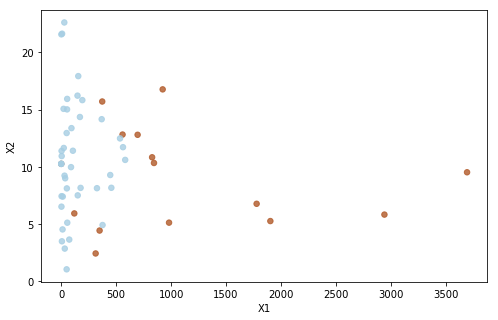

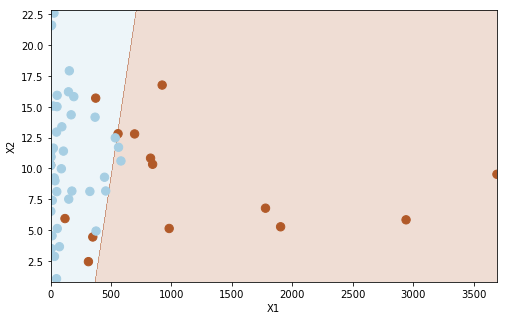

confusion matrix: 
    0   1
0  40   5
1   2  10
Classification Report: 
             precision    recall  f1-score   support

          0      0.889     0.952     0.920        42
          1      0.833     0.667     0.741        15

avg / total      0.874     0.877     0.872        57

Classification Accuracy Results: 


In [16]:
for i in range(1,2):
    print("index: " + str(i))
    svc, ww, wm, mm, mw = svm_classification(landmarks, i+1)
    print(svc, ww, wm, mm, mw)


### Testing One Sample

In [59]:
sample_1 = landmarks[landmarks.sample_index==101]
landmarks_1 = sample_1['landmark_index']

1405    38
1406    39
1407    40
1408    41
1409    42
1410    43
1411    44
1412    45
1413    46
1414    47
1415    48
1416    49
1417    50
1418    51
1419    52
1420    53
1421    54
1422    55
1423    56
1424    57
Name: landmark_index, dtype: int64

In [ ]:
results = []
for l in landmarks_1.values:
    print ("landmark: ", str(l))
    svc, accuracy = svm_classification(landmarks[landmarks.sample_index!=1], l)
    prediction = svc.predict(sample_1[sample_1.landmark_index==1][['pts', 'r']])
    results.append((l, prediction[0], accuracy))
    print(results)

In [65]:
r = [(1, 1, 0.5333333333333333), (2, 1, 0.8181818181818181), (3, 0, 0.4285714285714285), (4, 1, 0.8799999999999999), (5, 1, 0.47058823529411764), (6, 1, 0.6666666666666667), (7, 0, 0.4), (8, 1, 0.8571428571428571), (9, 1, 0.6666666666666665), (10, 1, 0.6), (11, 0, 0.625), (12, 1, 0.9230769230769231), (13, 0, 0.0), (14, 1, 0.8333333333333333), (15, 0, 0.5555555555555556), (16, 1, 0.9230769230769231), (17, 0, 0.4285714285714285), (18, 1, 0.6428571428571429), (19, 0, 0.5714285714285715), (20, 0, 0.7692307692307692), (21, 1, 0.5333333333333333), (22, 1, 0.5833333333333334), (23, 0, 0.3636363636363636), (24, 0, 0.6363636363636364), (25, 0, 0.0), (26, 1, 0.6153846153846153), (27, 0, 0.5714285714285714), (28, 1, 0.8333333333333334), (29, 1, 0.6666666666666665), (30, 1, 0.6666666666666666), (31, 0, 0.0), (32, 1, 1.0), (33, 0, 0.5), (34, 0, 0.0), (35, 0, 0.0), (36, 0, 0.0), (37, 0, 0.30769230769230765), (38, 0, 0.0), (39, 0, 0.3636363636363636), (40, 1, 0.6428571428571429), (41, 0, 0.7777777777777777), (42, 0, 0.0), (43, 0, 0.30769230769230765), (44, 0, 0.28571428571428575), (45, 0, 0.0), (46, 0, 0.0), (47, 0, 0.0), (48, 0, 0.0), (50, 0, 0.3636363636363636), (51, 0, 0.0), (52, 0, 0.0), (56, 0, 0.0), (81, 0, 0.18181818181818182), (82, 1, 0.6363636363636365), (83, 0, 0.3636363636363636), (84, 1, 0.631578947368421), (85, 1, 0.5333333333333333), (86, 0, 0.375), (87, 1, 0.5263157894736842), (88, 1, 0.5517241379310345), (89, 0, 0.0), (90, 0, 0.0), (91, 0, 0.0), (92, 0, 0.6956521739130435), (93, 0, 0.0), (94, 0, 0.631578947368421), (95, 0, 0.4285714285714285), (96, 0, 0.3333333333333333), (97, 0, 0.6), (98, 0, 0.0), (99, 0, 0.37499999999999994), (100, 0, 0.0), (101, 0, 0.37499999999999994), (102, 0, 0.7000000000000001), (103, 0, 0.625), (104, 0, 0.5263157894736842), (105, 1, 0.4285714285714285), (106, 1, 0.2857142857142857), (107, 0, 0.3333333333333333), (108, 1, 0.8799999999999999), (109, 1, 0.7499999999999999), (110, 1, 0.7826086956521738), (111, 1, 0.5333333333333333), (112, 1, 0.7368421052631579), (113, 0, 0.5333333333333333), (114, 0, 0.0), (115, 0, 0.0), (116, 0, 0.0), (117, 0, 0.75), (118, 0, 0.2857142857142857), (119, 0, 0.5), (120, 0, 0.0), (121, 0, 0.6), (122, 0, 0.0), (123, 0, 0.0)]

In [66]:
r_sig = []
for svm in r:
    if svm[2]>0.5:
        r_sig.append(svm)

In [67]:
print(len(r))
print(len(r_sig))

95
45


In [68]:
one = []
zero = []
for svm in r_sig:
    if svm[1]==1:
        one.append(svm)
    else:
        zero.append(svm)

In [69]:
print(len(one))
print(len(zero))

29
16


In [60]:
precision_score([1,1,1],[1,0,1])

1.0

In [69]:
y =   [1,0,1,1]
pre = [0,1,1,1]

In [71]:
ww =0
wm = 0
mm = 0
mw = 0
for i in range (len(y)):
    if y[i]==1 and pre[i]==1:
        mm = mm + 1
    elif y[i]==1 and pre[i]==0:
        mw = mw + 1
    elif y[i]==0 and pre[i]==0:
        ww = ww + 1
    elif y[i]==0 and pre[i]==1:
        wm = wm + 1

print(mm, mw, ww, wm)

2 1 0 1
